# Lung Cancer Detection Using CNNs

### Import libraries for data imports

In [1]:
import dicom
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

def show_img(image):
    plt.imshow(image)
    plt.show()

/Users/satchelgrant/miniconda3/envs/obama/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### Import and Convert Data

First I import the images and convert them to numpy arrays for experimentation and development.

In [2]:
external_drive_path = '/Volumes/WhiteElephant/'
home_path = os.getcwd()
os.chdir(external_drive_path)

In [3]:
path = './stage1/'

def file_walk(path):
    dcmFiles = []
    for dirName, subDirList, fileList in os.walk(path):
        for fileName in fileList:
            if '.dcm' in fileName.lower():
                dcmFiles.append(os.path.join(dirName,fileName))
    return dcmFiles

dcmFiles = file_walk(path)
            
id_labels = dict()
cancer_count = 0
with open('stage1_labels.csv', 'r') as labelFile:
    for i,line in enumerate(labelFile):
        if i == 0: continue
        p_id, cancer = line.strip().split(',')
        id_labels[p_id] = int(cancer)
        cancer_count += int(cancer)

In [4]:
patient_set = set()
for file in dcmFiles:
    p_id = file.split('/')[2]
    if p_id not in patient_set:
        patient_set.add(p_id)

In [5]:
print("Total Available Images: " + str(len(dcmFiles)))
print("Patients Diagnosed with Cancer: " + str(cancer_count))
print("Patients Not Diagnosed with Cancer: " + str(len(id_labels) - cancer_count))
print("Unlabeled Patients: " + str(len(patient_set)-len(id_labels)))
print("Total Number of Patients: " + str(len(patient_set)))

Total Available Images: 285380
Patients Diagnosed with Cancer: 362
Patients Not Diagnosed with Cancer: 1035
Unlabeled Patients: 198
Total Number of Patients: 1595


## Get Working Dataset

Instead of taking every image, a small number of images are taken from each patient for training, validation, and testing.


In [ ]:
imgs_per_patient = 4
imgs_per_patient_cancer = 8
img_count = imgs_per_patient*(len(patient_set)-cancer_count) + imgs_per_patient_cancer*cancer_count
img_shape = dicom.read_file(dcmFiles[0]).pixel_array.shape
bitstogb = 1.25*10**-10
print("Total Acquired Images: " + str(img_count))
print("Total Memory Size: " + str(img_count*img_shape[0]**2*32*bitstogb) + "GB")

In [ ]:
batching_counts = dict()
labeled_images = []
labels = []
unlabeled_images = []
unlabeled_ids = []
for file in dcmFiles:
    p_id = file.split('/')[2]
    if p_id not in batching_counts:
        batching_counts[p_id] = 0
    elif p_id not in id_labels and batching_counts[p_id] >= imgs_per_patient:
        continue
    elif p_id in id_labels and ((id_labels[p_id] == 0 and batching_counts[p_id] >= imgs_per_patient) or\
                            (id_labels[p_id] == 1 and batching_counts[p_id] >= imgs_per_patient_cancer)):
        continue
    batching_counts[p_id] += 1
    ref = dicom.read_file(file)
    if p_id in id_labels:
        labeled_images.append(ref.pixel_array)
        labels.append(id_labels[p_id])
    else:
        unlabeled_images.append(ref.pixel_array)
        unlabeled_ids.append(p_id)

labeled_images = np.array(labeled_images,dtype=np.float32)
labels = np.array(labels,dtype=np.float32)
unlabeled_images = np.array(unlabeled_images,dtype=np.float32)

In [ ]:
print("Labeled Data Shape (n_samples,rowpix,colpix): " + str(labeled_images.shape))
print("Unlabeled Data Shape (n_samples,rowpix,colpix): " + str(unlabeled_images.shape))
img_shape = (labeled_images.shape[1], labeled_images.shape[2])
print("Initial Image Shape: " + str(img_shape))


#### Split Images into Test, Validation, and Training Sets


In [ ]:
labeled_images, labels = shuffle(labeled_images, labels)

train_index = int(labeled_images.shape[0]*0.8)

train_images, train_labels = labeled_images[:train_index], labels[:train_index]
valid_images, valid_labels = labeled_images[train_index:], labels[train_index:]

print("Training Shape: " + str(train_images.shape))
print("\t Training Cancer Ratio: " + str(np.sum(train_labels)/train_labels.shape[0]))
print("Validation Shape: " + str(valid_images.shape))
print("\t Validation Cancer Ratio: " + str(np.sum(valid_labels)/valid_labels.shape[0]))
print("Test Shape: " + str(unlabeled_images.shape))

#### Pickle the Data (Only needed Once)

In [ ]:
import pickle

img_count = 800
num_sets = int(train_images.shape[0]/img_count)
for i in range(1,num_sets+1):
    pickle_d = dict()
    if i == num_sets:
        pickle_d['features'] = train_images[(i-1)*img_count:]
        pickle_d['labels'] = train_labels[(i-1)*img_count:]
        pickle.dump(pickle_d, open('train_set'+str(i)+'.p','wb'))
        break
    pickle_d['features'] = train_images[(i-1)*img_count:i*img_count]
    pickle_d['labels'] = train_labels[(i-1)*img_count:i*img_count]
    pickle.dump(pickle_d, open('train_set'+str(i)+'.p','wb'))

data_list = [valid_images[:img_count], valid_images[img_count:], unlabeled_images]
labels_list = [valid_labels[:img_count], valid_labels[img_count:], unlabeled_ids]
names = ['valid_set1', 'valid_set2', 'test']

for data,label,name in zip(data_list, labels_list, names):    
    pickle_d = dict()
    pickle_d['features'] = data
    pickle_d['labels'] = label
    pickle.dump(pickle_d, open(name + '.p','wb'))

In [ ]:
del data_list
del labels_list
del names
del pickle_d

#### Read From Pickled Files (Instead of Pipeline)

In [19]:
import pickle

def pickle2np(dicts):
    images = []
    labels = []
    for data_dict in dicts:
        images.append(data_dict['features'])
        labels.append(data_dict['labels'])
    return np.concatenate([img for img in images],axis=0), np.concatenate([lbl for lbl in labels], axis=0)

In [20]:
train_dicts = []
for i in range(1,8):
    path = './train_set'+str(i)+'.p'
    with open(path, mode='rb') as f:
        train_dicts.append(pickle.load(f))
train_images, train_labels = pickle2np(train_dicts)

In [21]:
valid_dicts = []
for i in range(1,3):
    path = './valid_set'+str(i)+'.p'
    with open(path, mode='rb') as f:
        valid_dicts.append(pickle.load(f))
valid_images, valid_labels = pickle2np(valid_dicts)
del valid_dicts

In [22]:
test_dicts = []
path = './test.p'
with open(path, 'rb') as f:
    test_dicts.append(pickle.load(f))
test_images, test_ids = pickle2np(test_dicts)
del test_dicts

### Visualization of Images

Next I wanted to see the data to try to understand what I am working with.

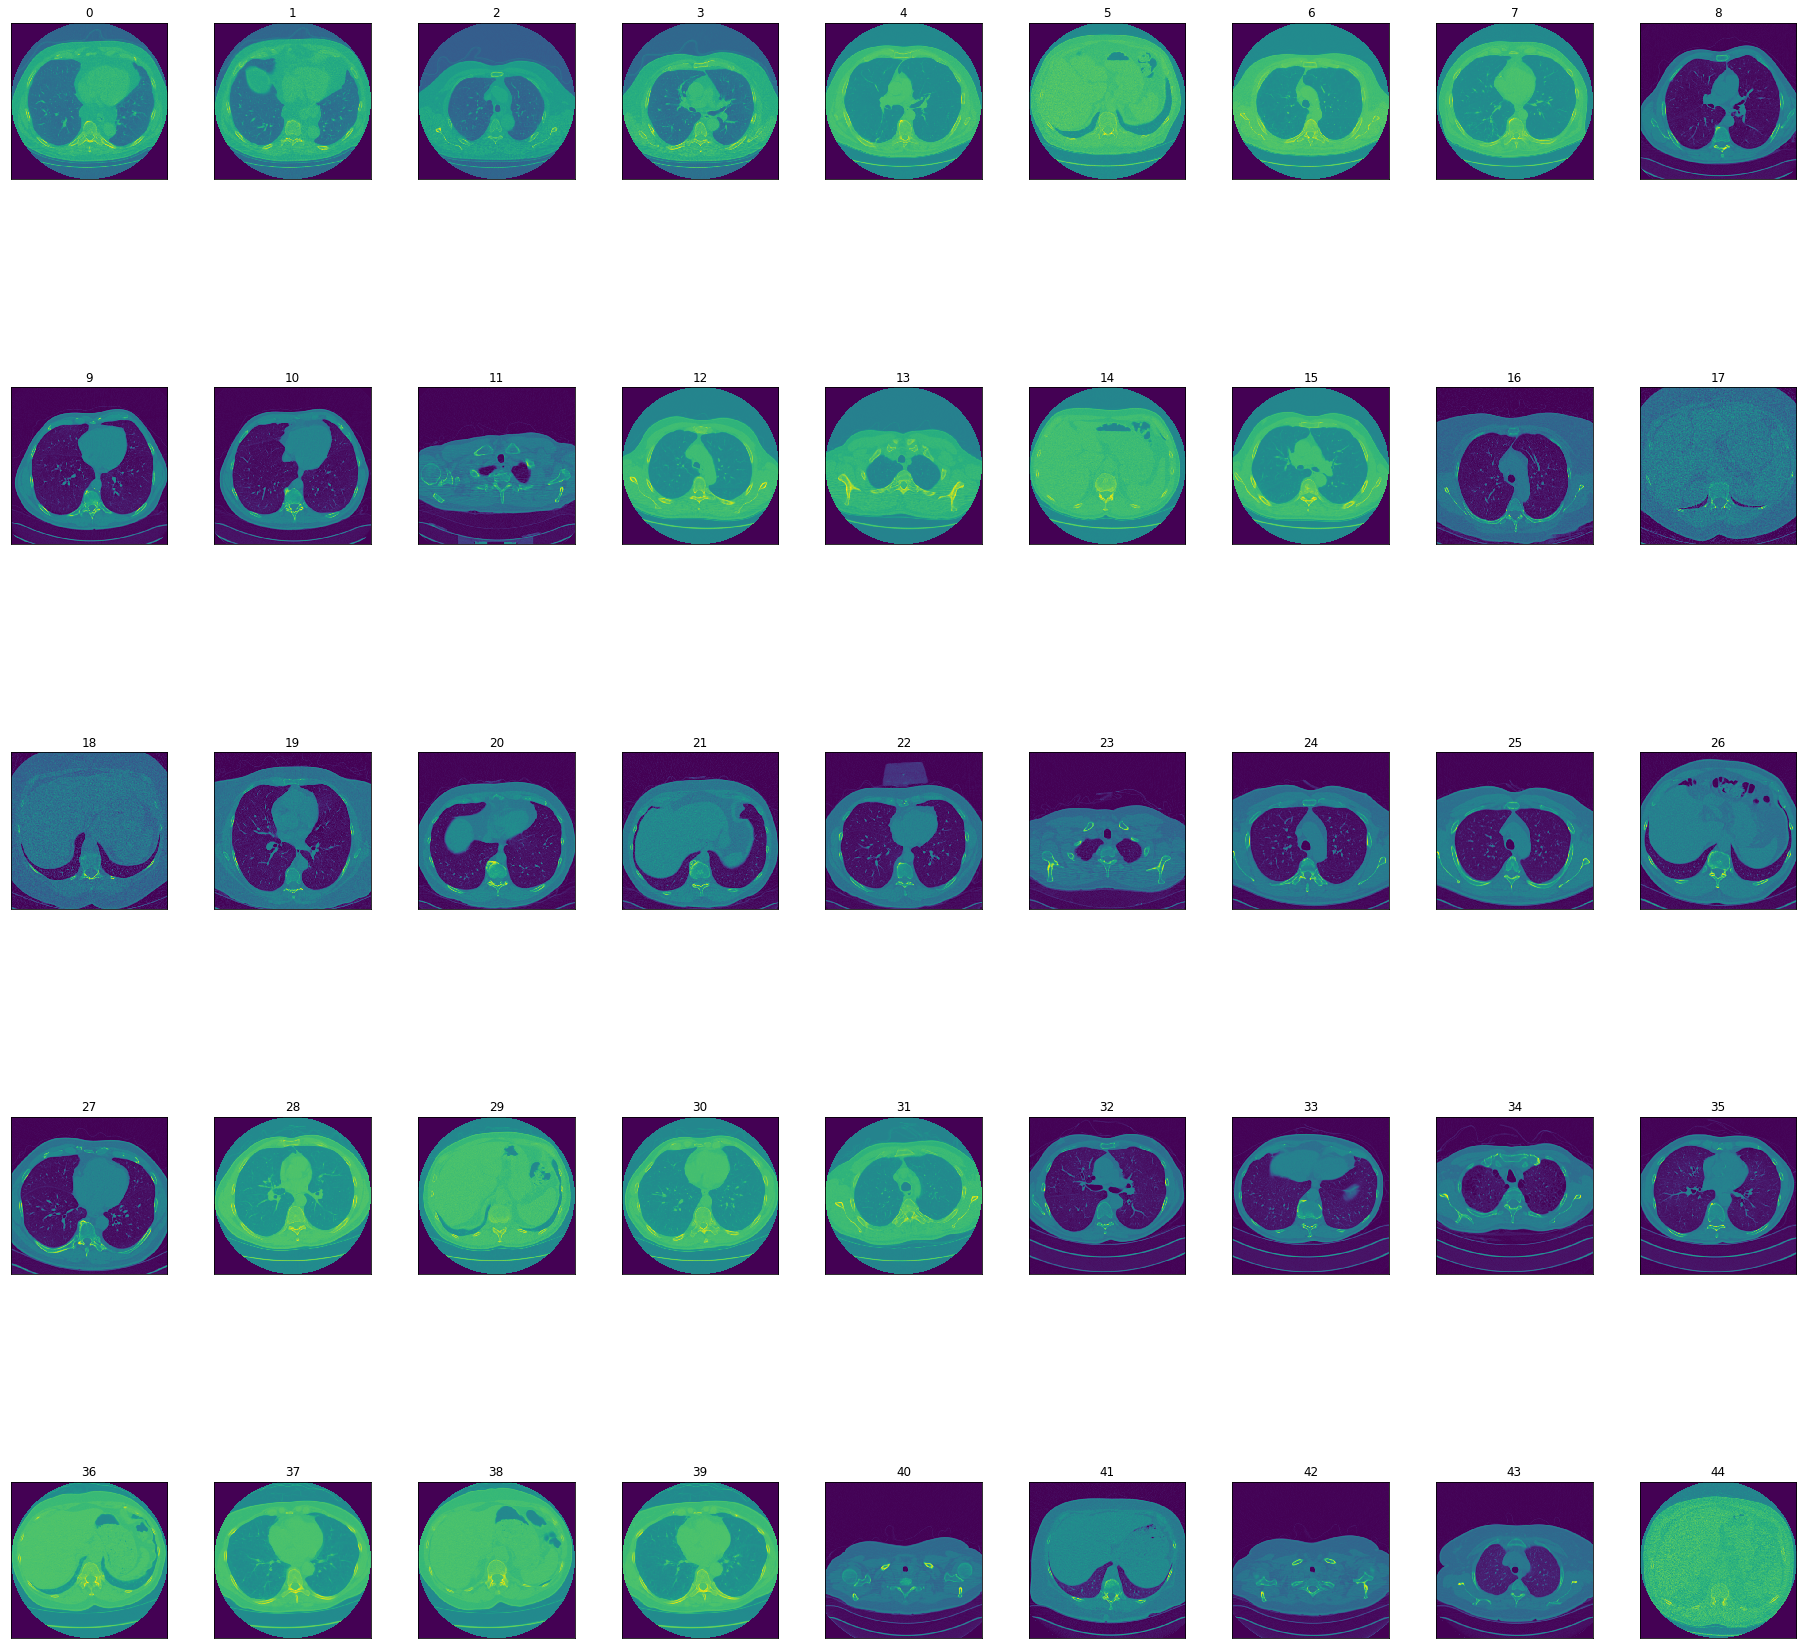

In [23]:
os.chdir(home_path)
fig_rows = 5
fig_cols = 9
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(32, 32),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i,ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    ax.set_title(str(i))
plt.savefig('readme_images/image_vis.png')
plt.show()

### Visualization of Data

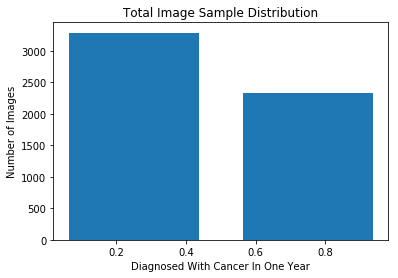

Percent Images Labeled with Cancer: 41.5600568586%


In [26]:
plotting_labels = [bool(x) for x in train_labels]
plt.hist(plotting_labels, 2, rwidth=.75)
plt.xlabel("Diagnosed With Cancer In One Year")
plt.ylabel("Number of Images")
plt.title("Total Image Sample Distribution")
plt.show()
cancer_count = np.sum(train_labels)
percent_cancer = cancer_count/train_labels.shape[0]
print("Percent Images Labeled with Cancer: " + str(percent_cancer*100) + "%")



## Preprocessing



In [27]:
def center_and_normalize(data, mu, dev):
    return (data-mu)/dev 

def rotate(image, angle, fill_val):
    rot_matrix = cv2.getRotationMatrix2D((image.shape[0]//2,image.shape[1]//2), angle, 1)
    return cv2.warpAffine(image, rot_matrix, dsize=(image.shape[0], image.shape[1]),
                          flags=cv2.INTER_LINEAR+cv2.WARP_FILL_OUTLIERS, borderValue=fill_val)

def rotate_data(images, labels, angles, fill_val):
    counter = images.shape[0]
    cancer_count = np.sum(labels)
    addons = cancer_count*4 + (labels.shape[0]-cancer_count)*2
    rotated_images = np.append(images,np.zeros([addons,images.shape[1],images.shape[2]],dtype=np.float32), axis=0)
    rotated_labels = []
    for i,img in enumerate(images):
        used_angles = angles
        if labels[i] == 1: used_angles = angles + [10,-10]
        for angle in used_angles:
            rotated_images[counter,:,:] = rotate(img,angle,fill_val)
            counter+=1
            rotated_labels.append(labels[i])
    labels = np.append(labels,rotated_labels,axis=0)
    return rotated_images, labels

def chop(image, img_size):
    limit = image.shape[0]//img_size
    chops = []
    for i in range(1,limit+1):
        for j in range(1,limit+1):
            chops.append(image[img_size*i-img_size:img_size*i,img_size*j-img_size:img_size*j])
    return chops

def chop_data(images, img_size):
    chopped_images = []
    print("Start Chopping")
    for i,img in enumerate(images):
        chopped_images.append(chop(img, img_size))
    print("End Chopping")
    return np.array(chopped_images, dtype=np.float32)

def one_hot_encode(labels, n_labels):
    encoded_labels = np.zeros((labels.shape[0], n_labels), dtype=np.float32)
    for i,label in enumerate(labels):
        encoded_labels[i,int(label)] = 1
    return encoded_labels

def preprocess(images, labels, mu, dev, angles=[-5,5], add_data=False):
    print("Start Initial Copies")
    images_copy = center_and_normalize(images, mu, dev)
    labels_copy = labels.copy()
    print("Finish Initial Copies")
    return images_copy, labels_copy


### Preprocessing Visualizations

In [ ]:
img_size = 32
chop_test = chop(train_images[0],img_size)

print("Unchopped Image")
show_img(labeled_images[0])
print("\nImage Chops")

fig, axes = plt.subplots(16, 16, figsize=(32, 32),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i,ax in enumerate(axes.flat):
    ax.imshow(chop_test[i])
    ax.set_title(str(i))
plt.savefig('readme_images/chops_vis.png')
plt.show()

In [28]:
process_mu = np.mean(train_images)
process_dev = np.std(train_images)

In [29]:
train_images, train_labels = preprocess(train_images, train_labels, process_mu, process_dev)
# train_chops = chop_data(train_images,32)

valid_images, valid_labels = preprocess(valid_images, valid_labels, process_mu, process_dev)
# valid_chops = chop_data(valid_images, 32)

test_images = center_and_normalize(test_images, process_mu, process_dev)

Start Initial Copies
Finish Initial Copies
Start Initial Copies
Finish Initial Copies


TypeError: center_and_normalize() missing 2 required positional arguments: 'mu' and 'dev'

In [30]:
test_images = center_and_normalize(test_images, process_mu, process_dev)

In [31]:
print(train_images.shape)

(5628, 512, 512)


In [32]:
train_images = train_images.reshape([train_images.shape[i] for i in range(3)]+[1])
valid_images = valid_images.reshape([valid_images.shape[i] for i in range(3)]+[1])
test_images = test_images.reshape([test_images.shape[i] for i in range(3)]+[1])
train_labels = one_hot_encode(train_labels,2)
valid_labels = one_hot_encode(valid_labels,2)


In [33]:
print(train_images.shape)

(5628, 512, 512, 1)



## Tensorflow Approach

#### Parameter Initializations

In [34]:
mu = 0
dev = 0.1

convweight_shapes = [
    # 512x512
    (5,5,1,64), # 508x508 stride=1
    (4,4,64,16), # 253x253 stride=2
    (5,5,16,50), # 125x125 stride=2
    (2,2,50,2), # 124x124 stride=1
    (2,2,2,2), # 62x62 stride=2
    (62,62,2,2)
]

convweights = [tf.Variable(tf.truncated_normal(shape=x,mean=mu,stddev=dev),name="reg_conv"+str(x[-1])) for x in convweight_shapes]
convbiases = [tf.Variable(tf.zeros([x[-1]]),name="reg_convbias"+str(x[-1])) for x in convweight_shapes]


In [ ]:
## Chopped Images Parameter Creation

mu = 0
dev = 0.1

chopped_convweight_shapes = [
    # 32x32
    (5,5,1,64), # 28x28
    # Pool: 14x14
    (5,5,64,16), # 10x10
    # Pool: 5x5
]
chopped_fcweight_shapes = [
    (5*5*16,50),
    (50,2),
    (2,1)
]

chopped_convweights = [tf.Variable(tf.truncated_normal(shape=x,mean=mu,stddev=dev),name="conv"+str(x[-1])) for x in chopped_convweight_shapes]
chopped_convbiases = [tf.Variable(tf.zeros([x[-1]]),name="convbias"+str(x[-1])) for x in chopped_convweight_shapes]

chopped_fcweights = [tf.Variable(tf.truncated_normal(shape=x,mean=mu,stddev=dev),name="fc"+str(x[-1])) for x in chopped_fcweight_shapes]
chopped_fcbiases = [tf.Variable(tf.zeros([x[-1]]),name="fcbias"+str(x[-1])) for x in chopped_fcweight_shapes]

combine_chops_weight = tf.Variable(tf.truncated_normal(shape=(((img_shape[0]//32)**2), 2), mean=mu, stddev=dev),name="combine")
combine_chops_bias = tf.Variable(tf.zeros([2]),name="combinebias")




In [35]:
def param_count(weight_shapes):
    total = 0
    for shape in weight_shapes:
        params = 1
        for dim in shape:
            params *= dim
        total += params + shape[-1]
    return total

print("Parameter Count")
print('Convolution Only: ' + str(param_count(convweight_shapes))+'\n')
# print("Chops: " + str(param_count(chopped_convweight_shapes)+param_count(chopped_fcweight_shapes)\
#                       +param_count([(((img_shape[0]//32)**2), 2)])) + "\n")

Parameter Count
Fwd Pass: 53912




#### Neural Net Helper Functions

In [36]:
def conv2d(data, weight, bias, stride=1, padding="VALID"):
    activations = tf.nn.bias_add(tf.nn.conv2d(data, weight,strides=[1,stride,stride,1],padding=padding),bias)
    return tf.nn.elu(activations)

def max_pool(data,k=2):
    return tf.nn.max_pool(data,ksize=[1,k,k,1],strides=[1,k,k,1],padding="VALID")

def conv_net(data, weights, biases, dropout_prob, strides=[]):
    if len(strides) == 0: strides = [1]*len(weights)
    logits = data
    for i,weight in enumerate(weights):
        logits = conv2d(logits, weight, biases[i],stride=strides[i])
#         logits = max_pool(logits)
        logits = tf.nn.dropout(logits, dropout_prob)
    return logits

def fc_net(data, weights, biases, dropout_prob):
    logits = data
    for i,weight in enumerate(weights):
        if i < len(weights)-1:
            logits = tf.matmul(logits, weight) + biases[i]
            logits = tf.nn.elu(logits)
    #         logits = tf.nn.dropout(logits, dropout_prob)
    return tf.matmul(logits,weights[-1])+biases[-1]

In [37]:
data_features = tf.placeholder(tf.float32, [None]+[train_images.shape[i] for i in range(1,len(train_images.shape))], name="data_features")
data_labels = tf.placeholder(tf.float32, [None, 2], name='data_labels')

convdropout = tf.placeholder(tf.float32, name="convdropout")
fcdropout = tf.placeholder(tf.float32, name="fcdropout")
momentum = tf.placeholder(tf.float32, name="momentum")
learning_rate = tf.placeholder(tf.float32, name="learning_rate")


In [38]:
## Convolution Only Architecture

logits = conv_net(data_features, convweights, convbiases, convdropout, strides=[1,2,2,1,2,1])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=data_labels))
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=momentum).minimize(cost)

equals_list = tf.equal(tf.argmax(logits,1), tf.argmax(data_labels,1))
accuracy = tf.reduce_mean(tf.cast(equals_list,tf.float32))

save_file = './net.ckpt'
saver = tf.train.Saver()

init = tf.global_variables_initializer()


In [ ]:
## Chopped Datas

batch_size = 100

def chopped_net(datas, conv_weights, conv_biases, fc_weights, fc_biases, batch_size, dropout_prob, strides=[]):
    combined_logits = []
    for i in range(batch_size):
        logits = conv_net(datas[i],conv_weights,conv_biases,dropout_prob,strides=strides)
        logits = tf.reshape(logits, [256,fc_weights[0].get_shape().as_list()[0]])
        logits = tf.nn.dropout(logits,dropout_prob)
        logits = fc_net(logits, fc_weights, fc_biases,dropout_prob)
        combined_logits.append(tf.reshape(logits,[256]))
    outputs = tf.stack(combined_logits)
    return outputs

def combine_chopped_logits(combined_logits, weight, bias):
    return tf.matmul(combined_logits, weight) + bias

In [ ]:
shapes = [shape for shape in train_chops.shape]
chopped_features = tf.placeholder(tf.float32, [None]+[shapes[i] for i in range(1,len(shapes))], name="chopped_features")

chopped_logits = chopped_net(chopped_features, chopped_convweights, chopped_convbiases, chopped_fcweights, chopped_fcbiases, batch_size, convdropout)
combined_logits = combine_chopped_logits(chopped_logits, combine_chops_weight, combine_chops_bias)

chopped_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=combined_logits,labels=data_labels))
chopped_optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=momentum).minimize(chopped_cost)

chopped_equals_list = tf.equal(tf.argmax(combined_logits,1), tf.argmax(data_labels,1))
chopped_accuracy = tf.reduce_mean(tf.cast(chopped_equals_list,tf.float32))

save_file = './net.ckpt'
saver = tf.train.Saver()

init = tf.global_variables_initializer()



## Session

#### Training

In [ ]:
## Helper Functions

def stop_early(loss,threshold):
    if len(loss) > 5:
        diffs = [loss[-i-1]-loss[-i] for i in range(5,0,-1)]
        if sum(diffs)/len(diffs) < threshold:
            return True
    return False

## Used to track hyperparameter experimentation
def write_to_file(file_name, weight_shapes, loss, rate, moment, epochs, batch_size, dropout_prob, acc):
    with open(file_name, 'a') as file:
        file.write("\nWeight shapes: \n")
        for weight in weight_shapes:
            file.write(str(weight) + str('\n'))
        file.write('Learning Rate: ' + str(rate) + '\n')
        file.write('Momentum: ' + str(moment) + '\n')
        file.write('Epoch Count: ' + str(epochs) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n')
        file.write("Dropout Probability: " + str(dropout_prob) + '\n')
        file.write('Loss: ' + str(loss) + '\n')
        file.write('Final Accuracy: ' + str(acc) + '\n\n')

## Covolution Only tf Session

In [ ]:
rate = .05
moment = .75
conv_dropout = .75
fc_dropout = .5
epochs = 6
batch_size = 100

with tf.Session() as sess:
    sess.run(init)
    print("Session Start")
    n_batches = int(train_images.shape[0]/batch_size)
    loss = []
    for epoch in range(epochs):
        print("Epoch: " + str(epoch+1))
        train_images, train_labels = shuffle(train_images, train_labels)
        running_cost = 0
        for batch in range(1,n_batches):
            batch_x = train_images[(batch-1)*batch_size:batch*batch_size]
            batch_y = train_labels[(batch-1)*batch_size:batch*batch_size]
            feed = {learning_rate: rate, momentum: moment,\
                                           convdropout: conv_dropout, fcdropout:fc_dropout,\
                                            data_features: batch_x, data_labels: batch_y}
            optcost = sess.run([optimizer, cost, accuracy], feed_dict=feed)
            running_cost += optcost[1]
            if batch % 10 == 0:
                print("Non-Cancer Percentage: " + str(1-np.sum(np.argmax(batch_y,1))/batch_size))
                print("Running Cost (Batch " + str(batch) + "): " + str(running_cost) + ", Acc: " + str(optcost[2]))
        loss.append(running_cost)
        valid_images, valid_labels = shuffle(valid_images, valid_labels)
        validation = {convdropout: 1.,fcdropout:1., data_features: valid_images[:batch_size], data_labels: valid_labels[:batch_size]}
        accost = sess.run([accuracy,cost], feed_dict=validation)
        print("\nActual Cancer Percentage: " + str(np.sum(np.argmax(valid_labels[:batch_size],1))/batch_size))
        print("Cost: " + str(accost[1]) + ", Accuracy: " + str(accost[0]))
        print("\n")
        saver.save(sess,save_file)
        
    feed = {learning_rate: rate, momentum: moment,\
                                   convdropout: 1., fcdropout: 1.,\
                                    data_features: valid_images, data_labels: valid_labels}
    acc = sess.run(accuracy, feed_dict=feed)
    print("Validation Accuracy: " + str(acc))

    plt.plot(np.arange(len(loss)), loss)
    plt.ylim([0,loss[0]])
    plt.title("Loss Over Training Epochs")
    plt.show()
        

Session Start
Epoch: 1


## Chopped tf Session

In [ ]:
rate = .05
moment = .75
conv_dropout = .5
fc_dropout = .5
epochs = 6

with tf.Session() as sess:
    sess.run(init)
    print("Session Start")
    n_batches = int(train_chops.shape[0]/batch_size)
    loss = []
    for epoch in range(epochs):
        print("Epoch: " + str(epoch+1))
        train_chops, train_labels = shuffle(train_chops, train_labels)
        running_cost = 0
        for batch in range(1,n_batches):
            batch_x = train_chops[batch*batch_size-batch_size:batch*batch_size]
            batch_y = train_labels[batch*batch_size-batch_size:batch*batch_size]
            feed = {learning_rate: rate, momentum: moment,\
                                           convdropout: conv_dropout, fcdropout:fc_dropout,\
                                            chopped_features: batch_x, data_labels: batch_y}
            optcost = sess.run([chopped_optimizer, chopped_cost, chopped_accuracy], feed_dict=feed)
            running_cost += optcost[1]
            if batch % 10 == 0:
                print("Non-Cancer Percentage: " + str(1-np.sum(np.argmax(batch_y,1))/batch_size))
                print("Running Cost (Batch " + str(batch) + "): " + str(running_cost) + ", Acc: " + str(optcost[2]))
        loss.append(running_cost)
        valid_chops, valid_labels = shuffle(valid_chops, valid_labels)
        validation = {convdropout: 1.,fcdropout:1., chopped_features: valid_chops[:batch_size], data_labels: valid_labels[:batch_size]}
        accost = sess.run([chopped_accuracy,chopped_cost], feed_dict=validation)
        print("\nActual Cancer Percentage: " + str(np.sum(np.argmax(valid_labels[:batch_size],1))/batch_size))
        print("Cost: " + str(accost[1]) + ", Accuracy: " + str(accost[0]))
        print("\n")
        saver.save(sess,save_file)
        

    n_batches = int(valid_chops.shape[0]/batch_size)
    running_acc = 0
    for batch in range(1,n_batches):
        batch_x = valid_chops[batch*batch_size-batch_size:batch*batch_size]
        batch_y = valid_labels[batch*batch_size-batch_size:batch*batch_size]
        feed = {learning_rate: rate, momentum: moment,\
                                       convdropout: 1., fcdropout: 1.,\
                                        chopped_features: batch_x, data_labels: batch_y}
        acc = sess.run(chopped_accuracy, feed_dict=feed)
        running_acc += acc
    print("Validation Accuracy: " + str(running_acc/n_batches))

    plt.plot(np.arange(len(loss)), loss)
    plt.ylim([0,loss[0]])
    plt.title("Loss Over Training Epochs")
    plt.show()
        

In [ ]:
n_datasets = 10

with tf.Session() as sess:
    print("Session Start\n")
    saver.restore(sess, save_file)
    for epoch in range(epochs):
        print("Epoch: " + str(epoch+1))
        for i in range(1,n_datasets+1):
            file_path = './chopped_data' + str(i) + '.p'
            with open(file_path, 'rb') as f:
                dataset_dict = pickle.load(f)
            chops = dataset_dict['features']
            labels = dataset_dict['labels']
            chops,labels = shuffle(chops,labels)
            n_batches = int(chops.shape[0]/batch_size)
            running_acc = 0
            for batch in range(1,n_batches):
                batch_x = chops[batch*batch_size-batch_size:batch*batch_size]
                batch_y = labels[batch*batch_size-batch_size:batch*batch_size]
                feed = {learning_rate: rate, momentum: moment,\
                                               convdropout: 1., fcdropout: 1.,\
                                                chopped_features: batch_x, data_labels: batch_y}
                acc = sess.run(chopped_accuracy, feed_dict=feed)
                running_acc += acc
            print("Test Accuracy: " + str(running_acc/n_batches))

## Large Scale Training

This training uses the pickled data sets


## Session



## Results
